In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import stackstac
import planetary_computer as pc
from dask.distributed import Client, LocalCluster
import warnings

warnings.filterwarnings("ignore")

# Import your modular function
from env_function import environmental_variables


In [3]:
cluster = LocalCluster(
    n_workers=4,
    threads_per_worker=2,
    memory_limit="8GB"
)

client = Client(cluster)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44649,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38785,Total threads: 2
Dashboard: http://127.0.0.1:43261/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:35651,


In [4]:
bbox = (-82.7167, 27.5833, -82.3833, 28.0333)  # Tampa Bay example
start_date = "2019-01-01"
end_date = "2024-12-31"

variables = ["sst", "precip"]


In [5]:
env_data = environmental_variables(
    bbox=bbox,
    start_date=start_date,
    end_date=end_date,
    variables=variables
)

sst_lazy = env_data["sst"]
precip_items = env_data["precip"]

type(sst_lazy), type(precip_items)


(xarray.core.dataarray.DataArray, list)

In [6]:
sst_lazy


<xarray.DataArray 'sst' (time: 24)> Size: 96B
dask.array<stack, shape=(24,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 192B 2019-01-31 2019-02-28 ... 2020-12-31

In [7]:
len(precip_items)


23198

In [8]:
# Refresh SAS tokens correctly (SIGN EACH ITEM)
for item in precip_items:
    pc.sign_inplace(item)

# Subsample for stability
max_items = 800
indices = np.linspace(
    0, len(precip_items) - 1,
    max_items,
    dtype=int
)
precip_sample = [precip_items[i] for i in indices]

# Stack lazily (no memory load yet)
precip_stack = stackstac.stack(
    precip_sample,
    assets=["cog"],
    epsg=4326,
    fill_value=np.nan
)

precip_stack


<xarray.DataArray 'stackstac-221ef44fc0f53450327621dfbf1bc504' (time: 800,
                                                                band: 1,
                                                                y: 7000, x: 3500)> Size: 157GB
dask.array<fetch_raster_window, shape=(800, 1, 7000, 3500), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time                  (time) datetime64[ns] 6kB 2020-10-15T17:00:00 ... 2...
    id                    (time) <U58 186kB 'CONUS_MRMS_MultiSensor_QPE_24H_P...
  * band                  (band) <U3 12B 'cog'
  * x                     (x) float64 28kB -130.0 -130.0 ... -60.04 -60.02
  * y                     (y) float64 56kB 55.0 54.99 54.99 ... 20.01 20.01
    noaa_mrms_qpe:pass    int64 8B 2
    ...                    ...
    proj:projjson         object 8B {'name': 'unknown', 'type': 'GeographicCR...
    description           <U55 220B 'Multi-sensor accumulation 24-hour (2-hou...
    title                 <U38 152B 'Processed Cloud Optimized GeoTIFF file'
    proj:transform        object 8B {0.009999999714244895, 0.0, -0.0099999997...
    proj:shape            object 8B {7000, 3500}
    epsg                  int64 8B 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-130.0, 20.0, -60.0, 55.0),...
    crs:            epsg:4326
    transform:      | 0.02, 0.00,-130.00|\n| 0.00,-0.01, 55.00|\n| 0.00, 0.00...
    resolution_xy:  (0.02, 0.005)

In [9]:
precip_monthly = (
    precip_stack
    .mean(dim=["x", "y"])
    .squeeze()
    .resample(time="1ME")
    .sum(min_count=1)
)

precip_monthly


<xarray.DataArray 'stackstac-221ef44fc0f53450327621dfbf1bc504' (time: 51)> Size: 408B
dask.array<where, shape=(51,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time                  (time) datetime64[ns] 408B 2020-10-31 ... 2024-12-31
    band                  <U3 12B 'cog'
    noaa_mrms_qpe:pass    int64 8B 2
    noaa_mrms_qpe:region  <U5 20B 'CONUS'
    noaa_mrms_qpe:period  int64 8B 24
    proj:projjson         object 8B {'name': 'unknown', 'type': 'GeographicCR...
    description           <U55 220B 'Multi-sensor accumulation 24-hour (2-hou...
    title                 <U38 152B 'Processed Cloud Optimized GeoTIFF file'
    proj:transform        object 8B {0.009999999714244895, 0.0, -0.0099999997...
    proj:shape            object 8B {7000, 3500}
    epsg                  int64 8B 4326

In [ ]:
test_df = xr.Dataset({
    "sst": sst_lazy,
    "precip": precip_monthly
}).compute().to_dataframe()

test_df.head()


In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import stackstac
import planetary_computer as pc
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Import your modular function
from env_function import environmental_variables

# Start Dask (safe + required)
cluster = LocalCluster(
    n_workers=4,
    threads_per_worker=2,
    memory_limit="8GB"
)
client = Client(cluster)

client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35311,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44173,Total threads: 2
Dashboard: http://127.0.0.1:38867/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:44771,


In [2]:
bbox = (-82.7167, 27.5833, -82.3833, 28.0333)  # Tampa Bay
start_date = "2019-01-01"
end_date = "2024-12-31"

env_data = environmental_variables(
    bbox=bbox,
    start_date=start_date,
    end_date=end_date,
    variables=["sst", "precip"]
)

sst_lazy = env_data["sst"]          # xarray DataArray (lazy)
precip_items = env_data["precip"]   # list of STAC Items

type(sst_lazy), type(precip_items)


(xarray.core.dataarray.DataArray, list)

In [3]:
# Refresh SAS tokens (SIGN EACH ITEM — REQUIRED)
for item in precip_items:
    pc.sign_inplace(item)

# Uniform subsample across entire time range
max_items = 800
indices = np.linspace(
    0, len(precip_items) - 1,
    max_items,
    dtype=int
)
precip_sample = [precip_items[i] for i in indices]

len(precip_sample)


800

In [4]:
precip_stack = stackstac.stack(
    precip_sample,
    assets=["cog"],
    epsg=4326,
    fill_value=np.nan
)

precip_monthly = (
    precip_stack
    .mean(dim=["x", "y"])
    .squeeze(drop=True)
    .resample(time="1ME")
    .sum(min_count=1)
)

precip_monthly


<xarray.DataArray 'stackstac-bfb3676394423ba61dfea80663daf1c4' (time: 51)> Size: 408B
dask.array<where, shape=(51,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time                  (time) datetime64[ns] 408B 2020-10-31 ... 2024-12-31
    description           <U55 220B 'Multi-sensor accumulation 24-hour (2-hou...
    proj:projjson         object 8B {'name': 'unknown', 'type': 'GeographicCR...
    noaa_mrms_qpe:pass    int64 8B 2
    noaa_mrms_qpe:period  int64 8B 24
    noaa_mrms_qpe:region  <U5 20B 'CONUS'
    proj:transform        object 8B {0.009999999714244895, 0.0, -0.0099999997...
    title                 <U38 152B 'Processed Cloud Optimized GeoTIFF file'
    proj:shape            object 8B {7000, 3500}
    epsg                  int64 8B 4326

In [5]:
final_ds = xr.Dataset({
    "sst": sst_lazy,
    "precip": precip_monthly
})

# Compute only the final result (safe)
final_df = final_ds.compute().to_dataframe()

final_df.head()


,sst,description,proj:projjson,noaa_mrms_qpe:pass,noaa_mrms_qpe:period,noaa_mrms_qpe:region,proj:transform,title,proj:shape,epsg,precip
time,,,,,,,,,,,
2019-01-31,17.589970,Multi-sensor accumulation 24-hour (2-hour late...,"{'name': 'unknown', 'type': 'GeographicCRS', '...",2,24,CONUS,"{0.009999999714244895, 0.0, -0.009999999714204...",Processed Cloud Optimized GeoTIFF file,"{7000, 3500}",4326,NaN
2019-02-28,19.669352,Multi-sensor accumulation 24-hour (2-hour late...,"{'name': 'unknown', 'type': 'GeographicCRS', '...",2,24,CONUS,"{0.009999999714244895, 0.0, -0.009999999714204...",Processed Cloud Optimized GeoTIFF file,"{7000, 3500}",4326,NaN
2019-03-31,21.761660,Multi-sensor accumulation 24-hour (2-hour late...,"{'name': 'unknown', 'type': 'GeographicCRS', '...",2,24,CONUS,"{0.009999999714244895, 0.0, -0.009999999714204...",Processed Cloud Optimized GeoTIFF file,"{7000, 3500}",4326,NaN
2019-04-30,24.227364,Multi-sensor accumulation 24-hour (2-hour late...,"{'name': 'unknown', 'type': 'GeographicCRS', '...",2,24,CONUS,"{0.009999999714244895, 0.0, -0.009999999714204...",Processed Cloud Optimized GeoTIFF file,"{7000, 3500}",4326,NaN
2019-05-31,27.806917,Multi-sensor accumulation 24-hour (2-hour late...,"{'name': 'unknown', 'type': 'GeographicCRS', '...",2,24,CONUS,"{0.009999999714244895, 0.0, -0.009999999714204...",Processed Cloud Optimized GeoTIFF file,"{7000, 3500}",4326,NaN


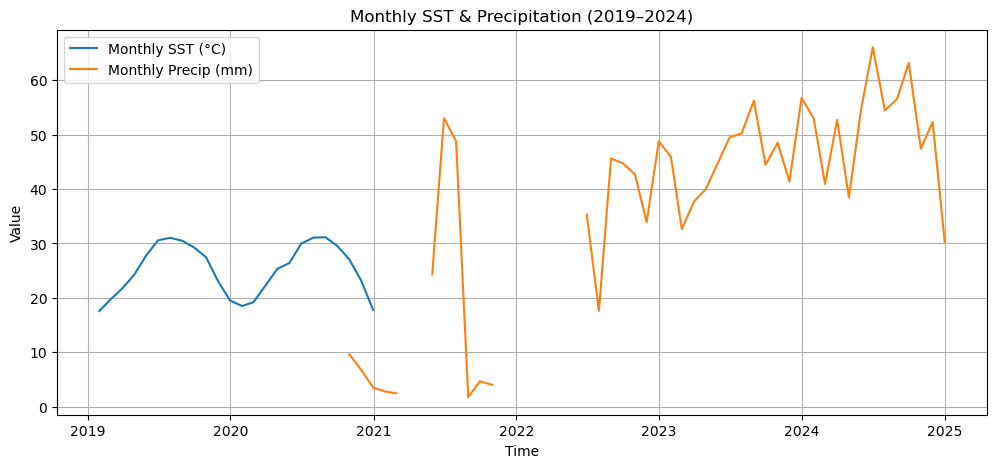

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(final_df.index, final_df["sst"], label="Monthly SST (°C)")
plt.plot(final_df.index, final_df["precip"], label="Monthly Precip (mm)")
plt.title("Monthly SST & Precipitation (2019–2024)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
csv_path = "kalu_environmental.csv"
final_df.to_csv(csv_path)

csv_path


'kalu_environmental.csv'

In [ ]:
# cell one 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from env_function import environmental_variables
import analysis  # your new module

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 4)

bbox = (-83.0, 27.3, -82.4, 28.0)
start = "2019-01-01"
end   = "2024-12-31"

env = environmental_variables(bbox, start, end, ["sst", "precip"])
sst = env["sst"]
precip = env["precip"]

# from Grace's code:
# ndwi_daily, ndci_daily, ndti_daily already computed for same bbox and dates


In [ ]:
# Cell 2: monthly and seasonal means using analysis.py

sst_aggr    = analysis.compute_monthly_seasonal_means(sst)
precip_aggr = analysis.compute_monthly_seasonal_means(precip)
ndwi_aggr   = analysis.compute_monthly_seasonal_means(ndwi_daily)
ndci_aggr   = analysis.compute_monthly_seasonal_means(ndci_daily)
ndti_aggr   = analysis.compute_monthly_seasonal_means(ndti_daily)

sst_monthly    = sst_aggr["monthly"]
precip_monthly = precip_aggr["monthly"]
ndwi_monthly   = ndwi_aggr["monthly"]
ndci_monthly   = ndci_aggr["monthly"]
ndti_monthly   = ndti_aggr["monthly"]

sst_season    = sst_aggr["seasonal"]
precip_season = precip_aggr["seasonal"]
ndwi_season   = ndwi_aggr["seasonal"]
ndci_season   = ndci_aggr["seasonal"]
ndti_season   = ndti_aggr["seasonal"]


In [ ]:
# Cell 3: time-series and seasonal-cycle plots

analysis.plot_time_series(sst_monthly,    "SST (°C)")
analysis.plot_time_series(precip_monthly, "Precipitation (mm/day)")
analysis.plot_time_series(ndci_monthly,   "NDCI")

analysis.plot_seasonal_cycle(ndci_daily,  "NDCI")
analysis.plot_seasonal_cycle(precip,      "Precipitation")


In [ ]:
# Cell 4: build monthly DataFrames and compute correlation matrix

wqi_df = xr.Dataset({
    "NDWI": ndwi_monthly,
    "NDCI": ndci_monthly,
    "NDTI": ndti_monthly,
}).to_dataframe()

env_df = xr.Dataset({
    "SST":   sst_monthly,
    "PRECT": precip_monthly,
}).to_dataframe()

corr_matrix = analysis.compute_correlation_matrix(wqi_df, env_df)
corr_matrix


In [ ]:
# Cell 5: RMSE examples

rmse_ndci_sst   = analysis.compute_rmse(ndci_monthly.values, sst_monthly.values)
rmse_ndci_prect = analysis.compute_rmse(ndci_monthly.values, precip_monthly.values)
rmse_ndti_sst   = analysis.compute_rmse(ndti_monthly.values, sst_monthly.values)
rmse_ndti_prect = analysis.compute_rmse(ndti_monthly.values, precip_monthly.values)

print("RMSE NDCI–SST:   ", rmse_ndci_sst)
print("RMSE NDCI–PRECT: ", rmse_ndci_prect)
print("RMSE NDTI–SST:   ", rmse_ndti_sst)
print("RMSE NDTI–PRECT: ", rmse_ndti_prect)


In [ ]:
# Cell 6: PCA on combined monthly indices + environmental variables

pca_results = analysis.compute_pca(wqi_df, env_df, n_components=2)
loadings = pca_results["loadings"]
loadings


In [ ]:
# Cell 6b: visualize PCA loadings

analysis.plot_pca_results(loadings)
